In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [23]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from helper import plot_confusion_matrix, metrics

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import utils, configs
import argparse

def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser

In [43]:
TEST_BATCH = 1000

@tf.function
def preproc(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.image.resize(x, size=[28,28])
    return x

with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    fashion_test = get_train_test_data("fashion_mnist")[1]
    fashion_test = fashion_test.shuffle(10000).batch(TEST_BATCH)
    fashion_test = fashion_test.cache()

    mnist_test = get_train_test_data("mnist")[1]
    mnist_test = mnist_test.shuffle(10000).batch(TEST_BATCH)
    mnist_test = mnist_test.cache()

    cifar_test = get_train_test_data("cifar10")[1]
    cifar_test = cifar_test.map(preproc)
    cifar_test = cifar_test.shuffle(10000).batch(TEST_BATCH)
    cifar_test = cifar_test.cache()

## FashionMNIST - Baseline --sigma_low=0.001

## Rechecking sigma=[1 , 1e-2]

In [6]:
args = get_command_line_args(["--checkpoint_dir=longleaf_models/",
                              "--filters=64",
                              "--dataset=fashion_mnist",
                              "--sigma_low=0.01",
                              "--sigma_high=1"
                             ])
configs.config_values = args

BEST_SIGMA_IDX = configs.config_values.num_L - 1
SIGMAS = utils.get_sigma_levels().numpy()
sigmas = SIGMAS

Parameters: 

experiment: train
dataset: fashion_mnist
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: longleaf_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2



In [7]:
utils.get_savemodel_dir()

('longleaf_models/refinenet64_fashion_mnist_L10_SH1e+00_SL1e-02/',
 'refinenet64_fashion_mnist_L10_SH1e+00_SL1e-02')

In [8]:
save_dir, complete_model_name = utils.get_savemodel_dir() # "longleaf_models/baseline64_fashion_mnist_SL0.001", ""
fashion_model, optimizer, step, _, _ = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

(1, 28, 28, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   640         images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 28, 28, 64)   77696       conv2d[0][0]                     
                                                                 idx_sigmas[0][

In [10]:
def compute_scores(x_test):
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = 0 #tf.zeros(logits_shape)
    progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]

        for x_batch in x_test:
            idx_sigmas = tf.ones(x_batch.shape[0], dtype=tf.int32) * idx
            score = fashion_model([x_batch, idx_sigmas])
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
#         final_logits += _logits * sigma
    
    return score_dict

### Getting Score Distributions

In [11]:
%%time

idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * BEST_SIGMA_IDX

for fashion_,mnist_,cifar_ in zip(fashion_test,mnist_test,cifar_test):    
    fashion_logits = fashion_model([fashion_, idx_sigmas])
    mnist_logits = fashion_model([mnist_, idx_sigmas])
    cifar_logits = fashion_model([cifar_, idx_sigmas])

CPU times: user 5.05 s, sys: 5.66 s, total: 10.7 s
Wall time: 4.45 s


In [12]:
# L2-norm same as Frobenius
f_train_fashion_score = tf.norm(fashion_logits, axis=[1,2], ord="euclidean").numpy()
f_train_mnist_score = tf.norm(mnist_logits, axis=[1,2], ord="euclidean").numpy()
f_train_cifar_score = tf.norm(cifar_logits, axis=[1,2], ord="euclidean").numpy()

In [13]:
df = pd.DataFrame(np.hstack((f_train_fashion_score,
                             f_train_mnist_score,
                             f_train_cifar_score)),
             columns=["Fashion", "MNIST", "Cifar"])
df.describe()

,Fashion,MNIST,Cifar
count,1000.000000,1000.000000,1000.000000
mean,815.579529,768.521240,1999.548340
std,220.375504,143.567154,285.049377
min,271.111206,334.031097,759.555847
25%,650.203430,679.442795,1866.361084
50%,795.221558,769.077637,2044.279541
75%,995.201416,863.716675,2191.764404
max,1584.942749,1254.009766,2589.728027


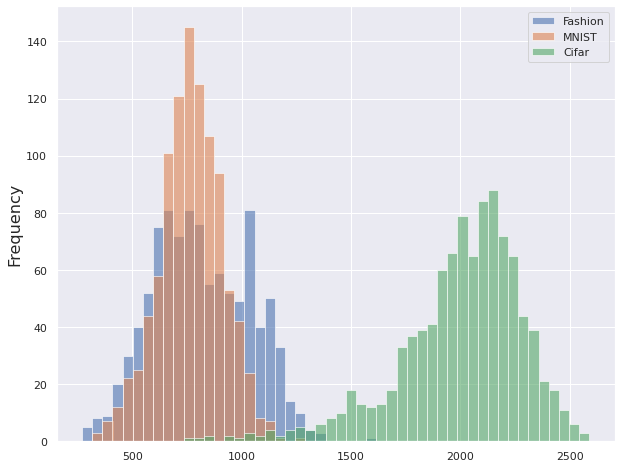

In [17]:
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))

### Fashion vs MNIST

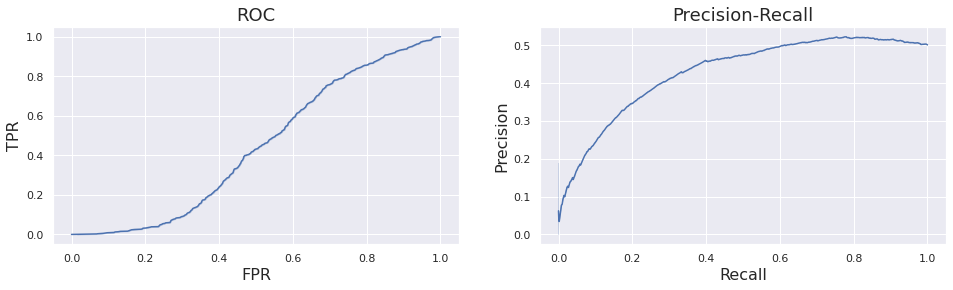

Inlier vs Outlier
----------------
ROC-AUC: 0.4438
PR-AUC: 0.4282
Avg Prec: 0.4287


In [25]:
metrics(f_train_fashion_score, f_train_mnist_score, plot=True, verbose=True)
plt.show()

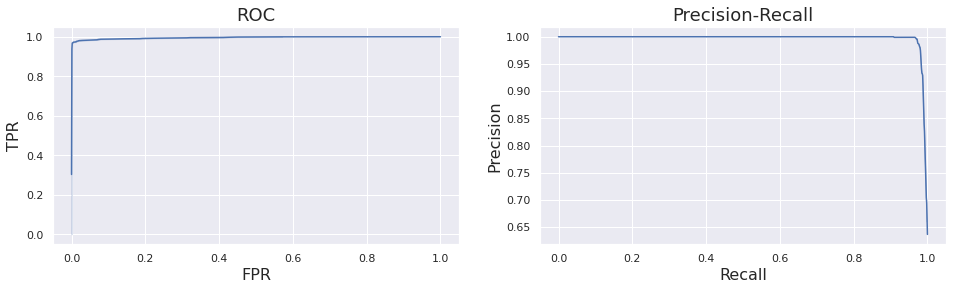

Inlier vs Outlier
----------------
ROC-AUC: 0.9958
PR-AUC: 0.9967
Avg Prec: 0.9967


In [26]:
metrics(f_train_fashion_score, f_train_cifar_score, plot=True, verbose=True)
plt.show()

In [44]:
%%time
fashion_dist = compute_scores(fashion_test)
mnist_dist = compute_scores(mnist_test)
cifar_dist = compute_scores(cifar_test)

Sigma: 0.0100: 100%|██████████| 10/10 [01:05<00:00,  6.53s/it]

CPU times: user 1min 37s, sys: 1min 44s, total: 3min 21s
Wall time: 3min 15s


## Training Distribution

In [ ]:
with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    fashion_train = get_train_test_data("fashion_mnist")[0]
    fashion_train = fashion_train.shuffle(100000).batch(1000).take(60)

In [ ]:
%%time
train_dist = compute_scores(fashion_train)

In [ ]:
-------------------

In [45]:
# L2-norm same as Frobenius
# train_agg = tf.add_n([train_dist[x] * s for x, s in enumerate(SIGMAS)])
inlier_agg = tf.add_n([fashion_dist[x] * s for x, s in enumerate(SIGMAS)])
outlier_agg = tf.add_n([mnist_dist[x] * s for x,s in enumerate(SIGMAS)])
outlier_agg_2 = tf.add_n([cifar_dist[x] * s for x,s in enumerate(SIGMAS)])

# train_score = tf.norm(train_agg, axis=[1,2], ord="euclidean").numpy()
fashion_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()
mnist_score = tf.norm(outlier_agg, axis=[1,2], ord="euclidean").numpy()
cifar_score = tf.norm(outlier_agg_2, axis=[1,2], ord="euclidean").numpy()

In [46]:
# df = pd.DataFrame(np.hstack((train_score[-len(fashion_score):],
#                              fashion_score,
#                              mnist_score,
#                              cifar_score)),
#              columns=["Train", "Fashion", "MNIST", "Cifar"])

df = pd.DataFrame(np.hstack((fashion_score,
                             mnist_score,
                             cifar_score)),
             columns=["Fashion", "MNIST", "CIFAR"])

df.describe()

,Fashion,MNIST,CIFAR
count,10000.000000,10000.000000,10000.000000
mean,73.338264,64.612488,149.292480
std,13.330881,3.759705,21.777611
min,39.564793,49.384815,68.431046
25%,63.762892,62.168112,135.765732
50%,72.237339,64.592098,150.494133
75%,82.374416,67.134315,164.379520
max,140.977722,82.665604,229.783051


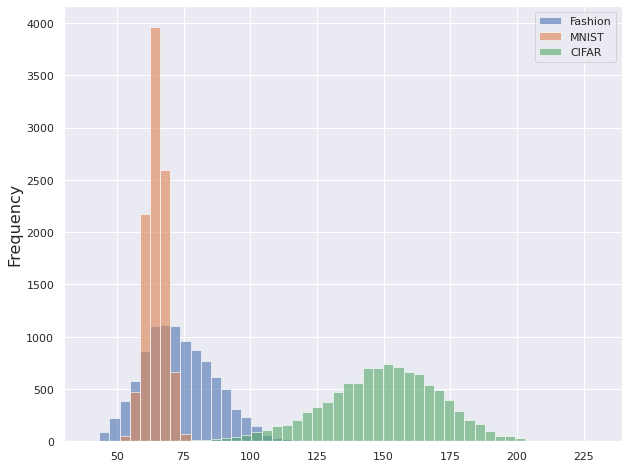

In [47]:
df.plot(kind="hist", bins=50, alpha=0.6, figsize=(10,8))

In [48]:
LABELS = np.array(["Train", "Fashion", "MNIST", "CIFAR"])

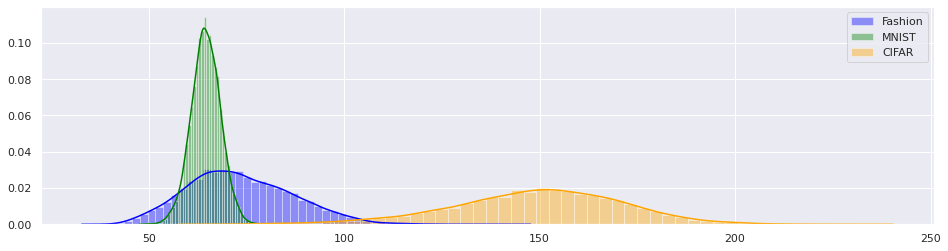

In [49]:
fig, ax = plt.subplots(1,1, figsize=(16,4))

colors = ["red", "blue", "green", "orange"]

for idx, sc in enumerate([fashion_score,
                          mnist_score,
                          cifar_score]):

    sns.distplot(sc, label=LABELS[idx+1], color=colors[idx+1], ax=ax)
plt.legend()
plt.show()

**Fashion vs MNIST**

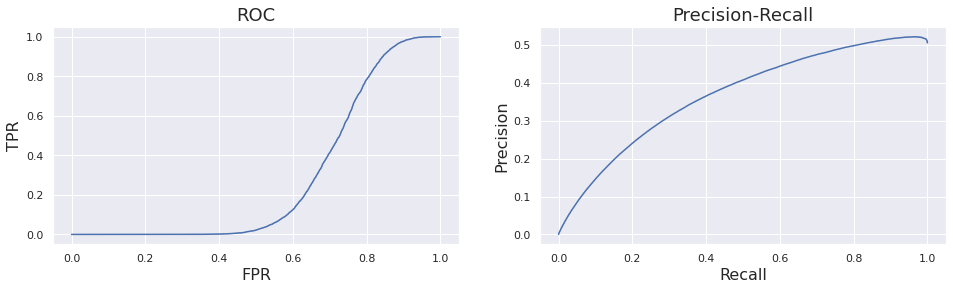

Inlier vs Outlier
----------------
ROC-AUC: 0.2825
PR-AUC: 0.3681
Avg Prec: 0.3681


In [50]:
metrics(fashion_score, mnist_score, plot=True, verbose=True)
plt.show()

**Fashion vs CIFAR**

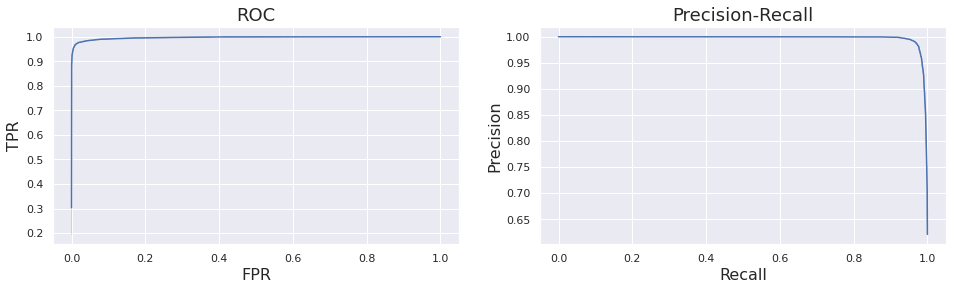

Inlier vs Outlier
----------------
ROC-AUC: 0.9968
PR-AUC: 0.9972
Avg Prec: 0.9972


In [51]:
metrics(fashion_score, cifar_score, plot=True, verbose=True)
plt.show()

### Visualizing Sigma Distributions



Sigma: ?:   0%|          | 0/10 [00:00<?, ?it/s]

Sigma: ?:  20%|██        | 2/10 [00:00<00:00, 16.71it/s]

Sigma: ?: 100%|██████████| 10/10 [00:00<00:00, 30.58it/s][A


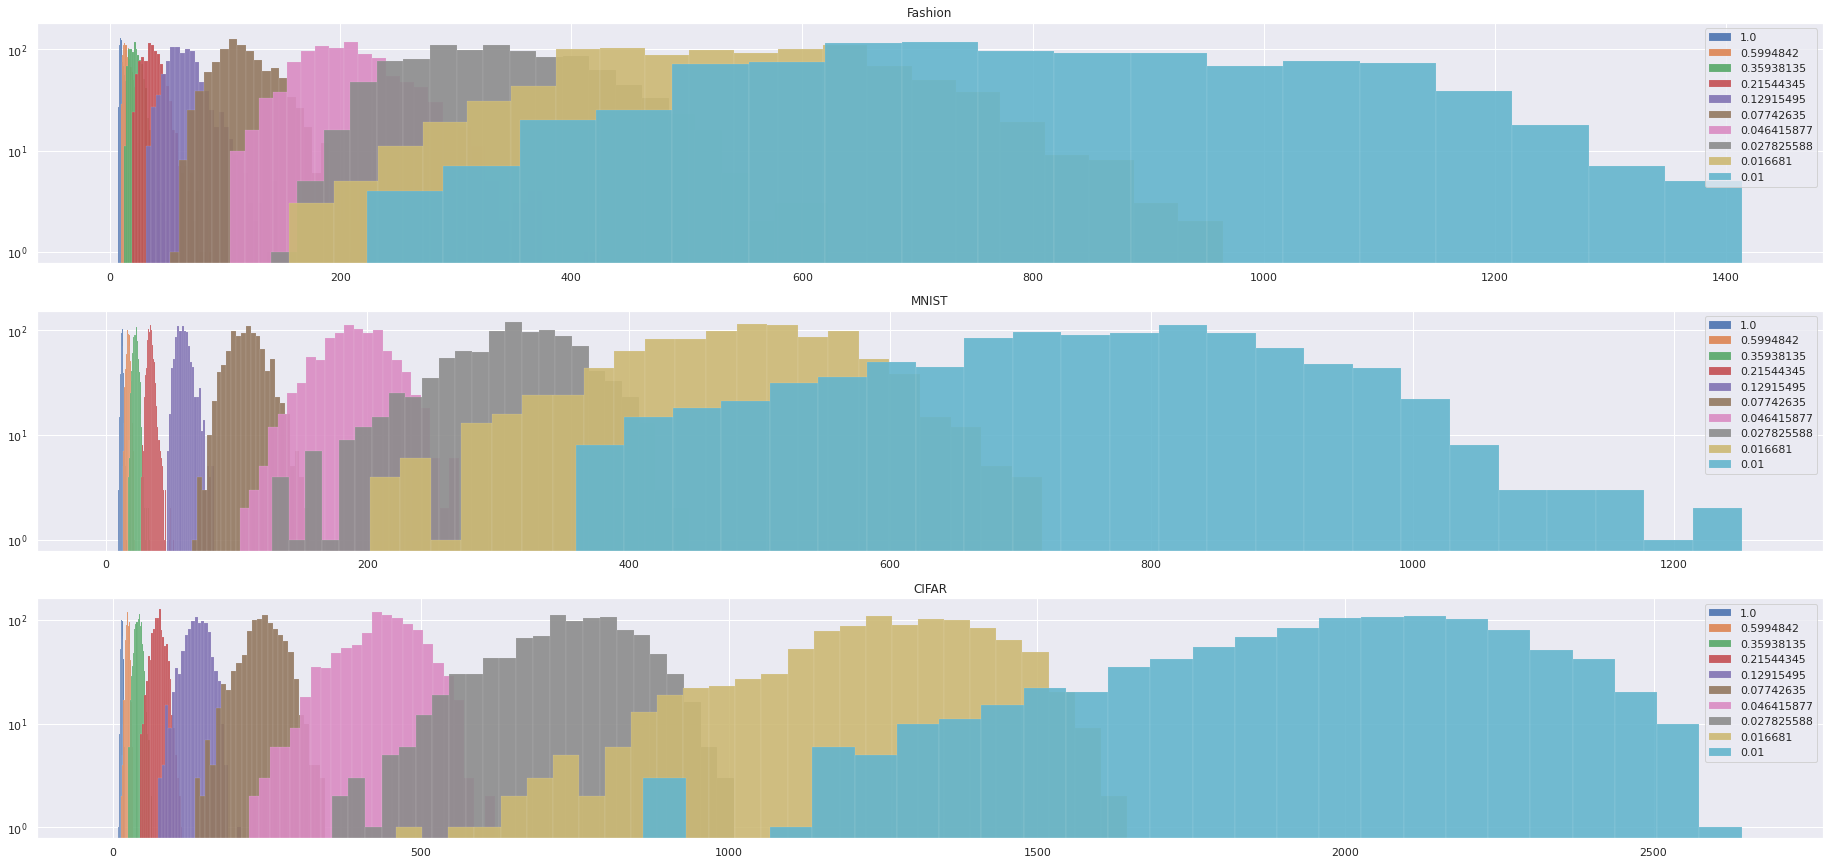

In [97]:
progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(3,1, figsize=(32,15))

for i, score_dict in enumerate([fashion_dist, mnist_dist, cifar_dist]):
    for idx, sigma in enumerate(progress_bar):
        _logits = score_dict[idx]
        _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
        sns.distplot(_score, label=sigma, ax=axs[i], hist_kws={"alpha":0.9, "linewidth": 0.1, "log":True}, kde=False)
        axs[i].legend()
        
axs[0].set(title="Fashion")    
axs[1].set(title="MNIST") 
axs[2].set(title="CIFAR")
plt.show()



Sigma: ?:   0%|          | 0/10 [00:00<?, ?it/s]

Sigma: ?:  20%|██        | 2/10 [00:00<00:00, 16.18it/s]

Sigma: ?:  50%|█████     | 5/10 [00:00<00:00, 18.65it/s]

Sigma: ?: 100%|██████████| 10/10 [00:00<00:00, 25.31it/s][A


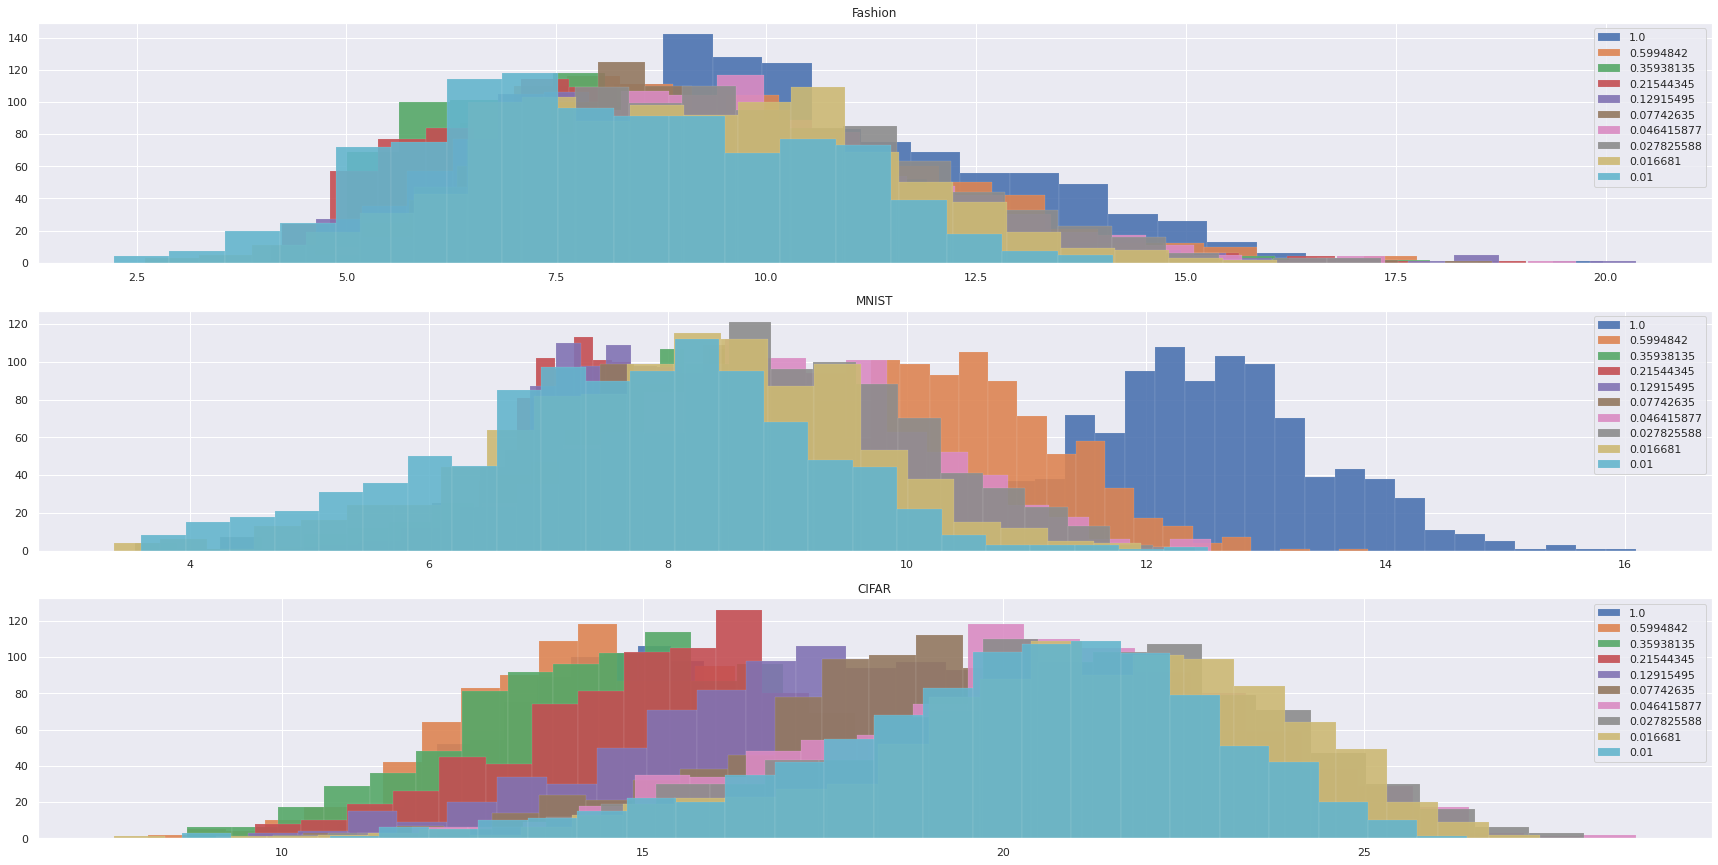

In [99]:
progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(3,1, figsize=(30,15))

for i, score_dict in enumerate([fashion_dist, mnist_dist, cifar_dist]):
    for idx, sigma in enumerate(progress_bar):
        _logits = score_dict[idx] * sigma
        _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
        sns.distplot(_score, label=sigma, ax=axs[i], hist_kws={"alpha":0.9, "linewidth": 0.1, "log":False}, kde=False)
        axs[i].legend()
        
axs[0].set(title="Fashion")    
axs[1].set(title="MNIST") 
axs[2].set(title="CIFAR")
plt.show()

In [35]:
sigmas

array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [53]:
df_arr = []

for (x_dist, name) in zip([fashion_dist, mnist_dist, cifar_dist],
                        ["Fashion", "MNIST", "CIFAR"]):
    print(name)
    dist_tf = tf.squeeze(tf.stack(x_dist)) * sigmas.reshape(-1,1,1,1)
    norms = tf.norm(dist_tf, axis=[2,3], ord="euclidean").numpy()
    _df = pd.DataFrame(norms.T, columns=["{:.2f}".format(x) for x in sigmas])
    _df["ID"] = _df.index
    _df["Type"] = name
    
    df_arr.append(_df.copy())

df = pd.concat(df_arr)

melted=df.melt(id_vars=["ID", "Type"], var_name="sigma", value_name="score")
# melted

Fashion
MNIST
CIFAR


In [54]:
df

,1.00,0.60,0.36,0.22,0.13,0.08,0.05,0.03,0.02,0.01,ID,Type
0,9.594316,8.547364,7.841166,7.937465,9.092659,11.749896,15.286146,13.977040,9.566351,6.911415,0,Fashion
1,8.721970,6.930758,5.738671,5.591466,5.957443,6.481417,7.258493,7.953663,8.103520,7.473018,1,Fashion
2,11.203454,9.995947,7.972720,7.451239,7.531382,7.791274,7.726144,7.352177,6.853808,6.640557,2,Fashion
3,9.263767,7.775439,6.747206,6.582698,6.993603,7.819567,7.854207,8.015529,7.903569,7.021515,3,Fashion
4,9.384685,8.342473,7.618414,7.689899,8.490829,8.966666,9.328708,10.098785,10.377403,9.361619,4,Fashion
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,18.959463,17.412342,16.895136,17.688684,18.538074,19.473322,21.894739,23.369392,24.189125,23.275860,9995,CIFAR
9996,16.999983,17.132551,17.464226,18.421038,20.257601,21.397568,22.115479,22.311008,21.525455,19.574852,9996,CIFAR
9997,17.416639,18.803217,19.769146,20.662743,21.581707,20.848829,21.519594,21.250563,20.541096,19.482044,9997,CIFAR
9998,15.257476,14.805135,15.009276,16.000853,17.828566,18.587006,19.431528,19.631586,19.218784,18.509258,9998,CIFAR


In [55]:
melted

,ID,Type,sigma,score
0,0,Fashion,1.00,9.594316
1,1,Fashion,1.00,8.721970
2,2,Fashion,1.00,11.203454
3,3,Fashion,1.00,9.263767
4,4,Fashion,1.00,9.384685
...,...,...,...,...
299995,9995,CIFAR,0.01,23.275860
299996,9996,CIFAR,0.01,19.574852
299997,9997,CIFAR,0.01,19.482044
299998,9998,CIFAR,0.01,18.509258


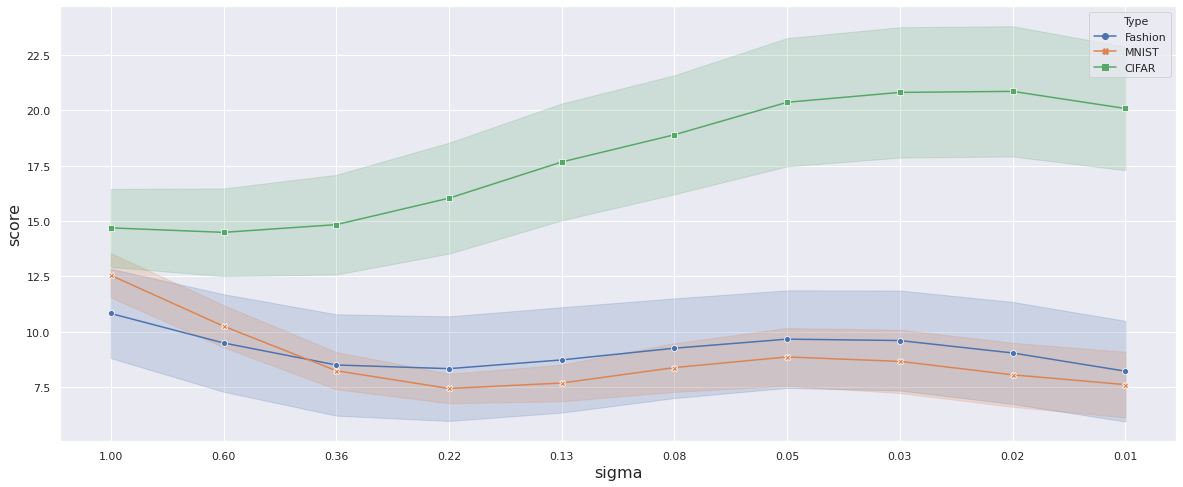

CPU times: user 1.72 s, sys: 68.1 ms, total: 1.78 s
Wall time: 1.78 s


In [56]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, err_style="band", ci="sd", ax=ax, style="Type", markers=True, dashes=False)
ax.invert_xaxis()
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

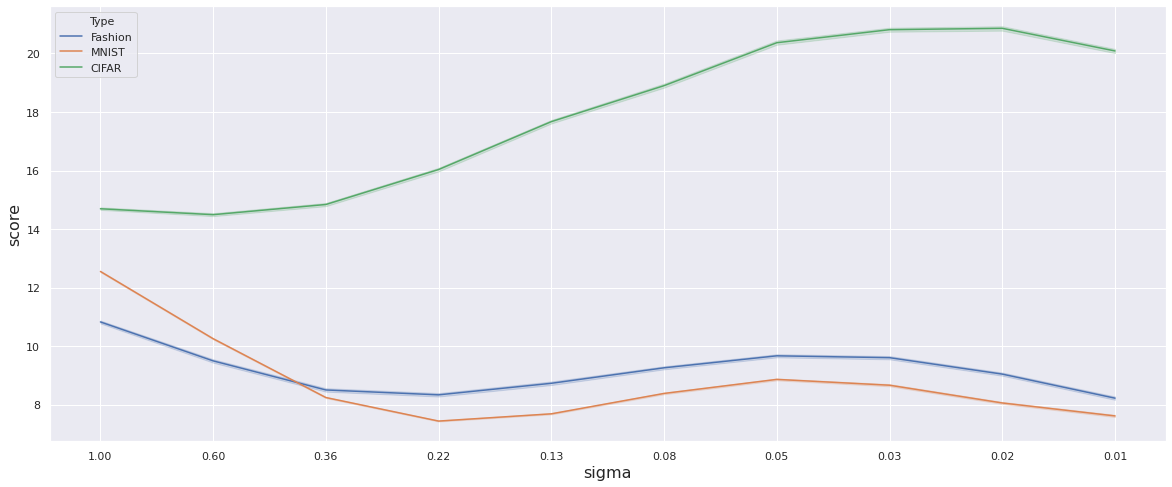

CPU times: user 5.42 s, sys: 189 ms, total: 5.61 s
Wall time: 5.6 s


In [57]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, err_style="band", ci=99, ax=ax)
ax.invert_xaxis()
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

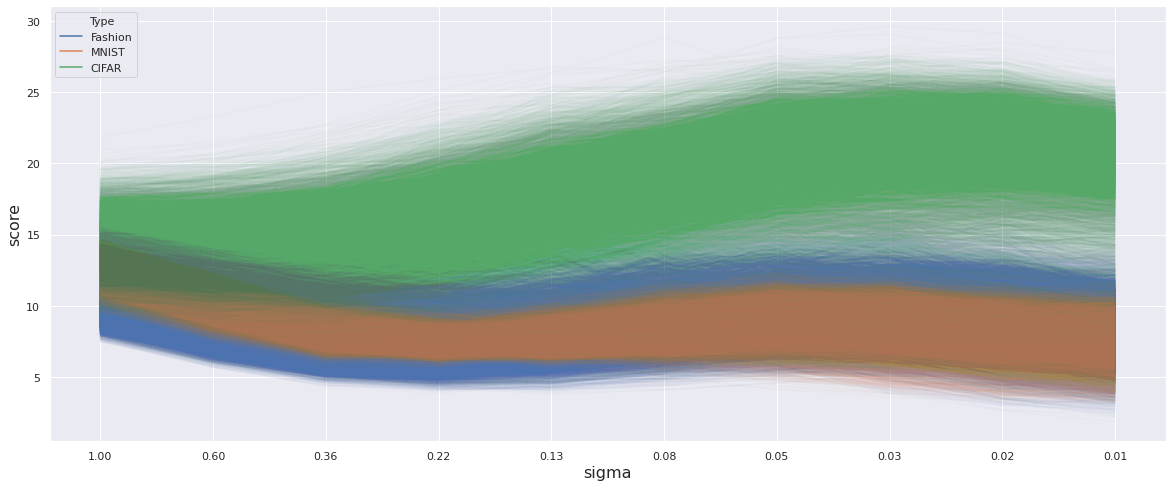

CPU times: user 1min 21s, sys: 5.46 s, total: 1min 27s
Wall time: 1min 27s


In [58]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, units="ID", estimator=None, alpha=0.02, ax=ax)
ax.invert_xaxis()
plt.show()

In [77]:
# progress_bar = tqdm(sigmas, desc='Sigma: ?')
# fig, axs = plt.subplots(5,2, figsize=(16,20))
# axs = axs.flatten()

# for idx, sigma in enumerate(progress_bar):
#     for (score_dist, name) in zip([fashion_dist, mnist_dist, cifar_dist], 
#                               ["Fashion", "MNIST", "CIFAR"]):
#         _logits = score_dist[idx] * sigma
#         _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
#         sns.distplot(_score, label=name, ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
#     textstr = '\n'.join((
#         'AUC',
#         "-----",
#         'F vs M=%.2f' % (0.433, ),
#         'F vs C=%.2f' % (0.992, )))

#     # these are matplotlib.patch.Patch properties
#     props = dict(boxstyle='round', alpha=0.5)

#     # place a text box in upper left in axes coords
#     axs[idx].text(0.05, 0.95, textstr, transform=axs[idx].transAxes, fontsize=14,
#             verticalalignment='top', bbox=props)
        
#     break
# axs[0].legend()
# plt.show()

Sigma: ?: 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


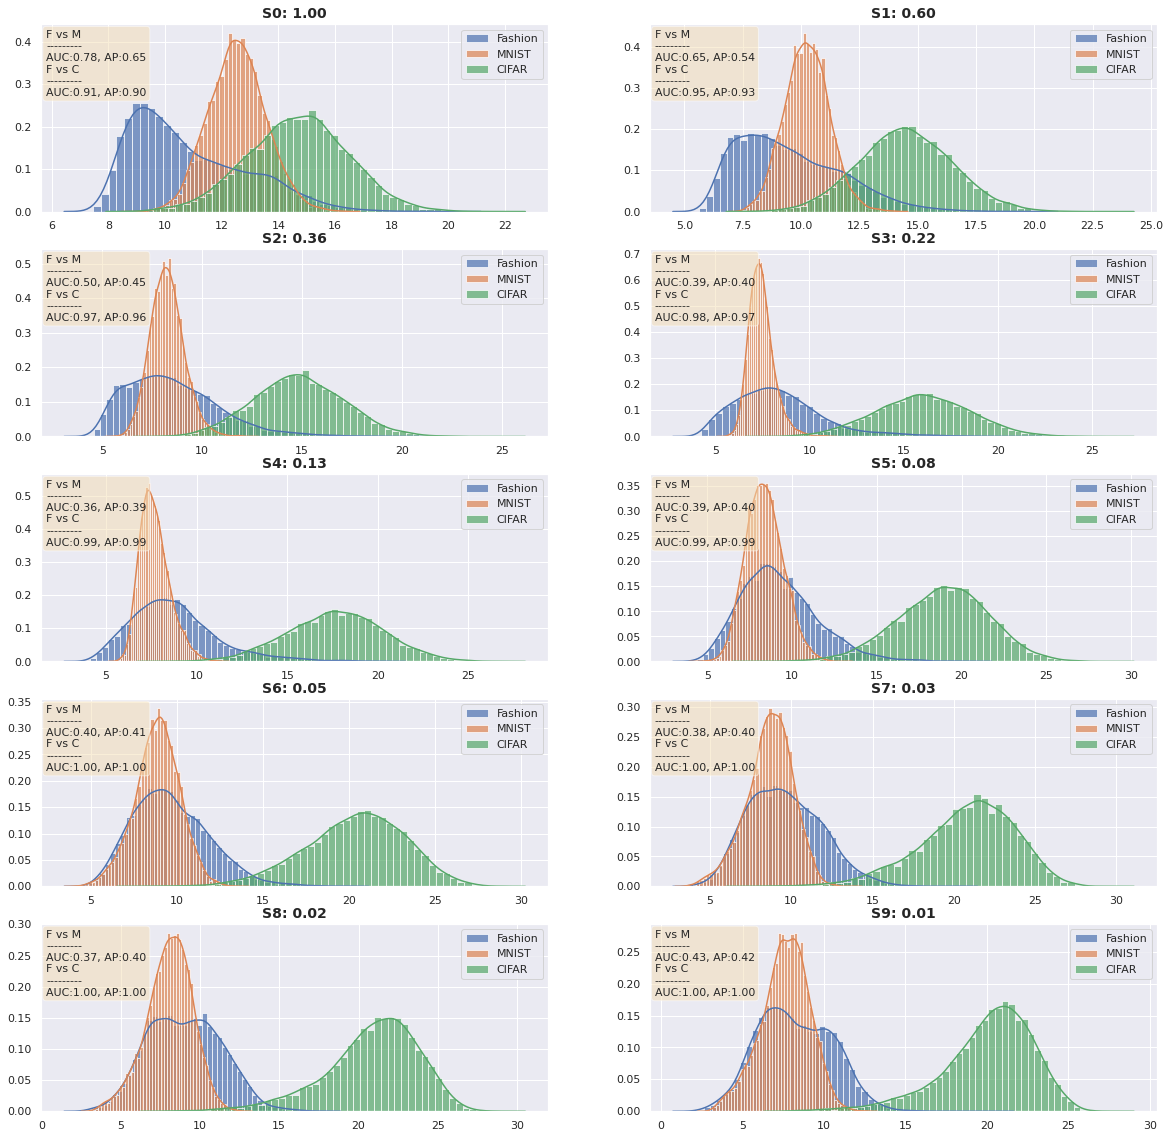

In [59]:
progress_bar = tqdm(sigmas, desc='Sigma: ?')
fig, axs = plt.subplots(5,2, figsize=(20,20))
axs = axs.flatten()

for idx, sigma in enumerate(progress_bar):

    # Fashion Scores
    f_logits = fashion_dist[idx] * sigma
    f_score =  tf.norm(f_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(f_score, label="Fashion", ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
    m_logits = mnist_dist[idx] * sigma
    m_score =  tf.norm(m_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(m_score, label="MNIST", ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
    c_logits = cifar_dist[idx] * sigma
    c_score =  tf.norm(c_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(c_score, label="CIFAR", ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
    textstr = '\n'.join((
        'F vs M',
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(f_score, m_score)[:-1]),
        'F vs C',
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(f_score, c_score)[:-1])))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[idx].text(0.01, 0.97, textstr, transform=axs[idx].transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    axs[idx].set_title("S{:d}: {:.2f}".format(idx, sigma), fontsize=14, fontweight="bold")

    axs[idx].legend()
    
plt.show()

### Picking "best" sigmas

In [151]:
sigmas

array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [159]:
# L2-norm same as Frobenius
idx_range = range(0,4)
inlier_agg = tf.add_n([fashion_dist[x] * sigmas[x] for x in idx_range])
outlier_agg = tf.add_n([mnist_dist[x] * sigmas[x] for x in idx_range])
outlier_agg_2 = tf.add_n([cifar_dist[x] * sigmas[x] for x in idx_range])

f_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()
m_score = tf.norm(outlier_agg, axis=[1,2], ord="euclidean").numpy()
c_score = tf.norm(outlier_agg_2, axis=[1,2], ord="euclidean").numpy()

df = pd.DataFrame(np.concatenate((f_score, 
                                  m_score,
                                  c_score), axis=-1),
             columns=["Fashion", "MNIST", "CIFAR"])
df.describe()

,Fashion,MNIST,CIFAR
count,1000.000000,1000.000000,1000.000000
mean,20.912781,22.416807,33.380936
std,2.228488,1.406081,3.132501
min,15.649920,18.309240,23.564169
25%,19.319313,21.497686,31.236532
50%,20.706662,22.391023,33.357744
75%,22.303570,23.220737,35.478958
max,28.460979,28.650320,44.251629


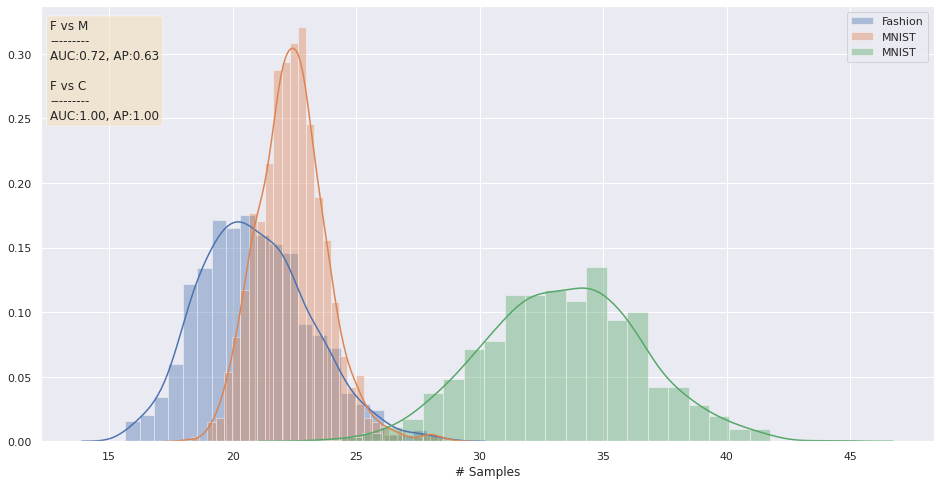

In [164]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
sns.distplot(f_score, label="Fashion", ax=ax)
sns.distplot(m_score, label="MNIST", ax=ax)
sns.distplot(c_score, label="MNIST", ax=ax, axlabel="# Samples")

textstr = '\n'.join((
    'F vs M',
    "---------",
    'AUC:%.2f, AP:%.2f' % (metrics(f_score, m_score)[:-1]),
    '',
    'F vs C',
    "---------",
    'AUC:%.2f, AP:%.2f' % (metrics(f_score, c_score)[:-1])))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.01, 0.97, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)


plt.legend()
plt.show()

In [175]:
plt.close()



Sigma: ?:   0%|          | 0/10 [00:00<?, ?it/s]

Sigma: ?:  10%|█         | 1/10 [00:06<01:00,  6.68s/it]

Sigma: ?:  20%|██        | 2/10 [00:13<00:52,  6.60s/it]

Sigma: ?:  30%|███       | 3/10 [00:19<00:45,  6.44s/it]

Sigma: ?:  40%|████      | 4/10 [00:25<00:38,  6.38s/it]

Sigma: ?:  50%|█████     | 5/10 [00:30<00:30,  6.14s/it]

Sigma: ?:  60%|██████    | 6/10 [00:36<00:23,  5.86s/it]

Sigma: ?:  70%|███████   | 7/10 [00:41<00:16,  5.56s/it]

Sigma: ?:  80%|████████  | 8/10 [00:46<00:11,  5.50s/it]

Sigma: ?:  90%|█████████ | 9/10 [00:52<00:05,  5.58s/it]

Sigma: ?: 100%|██████████| 10/10 [00:57<00:00,  5.71s/it]


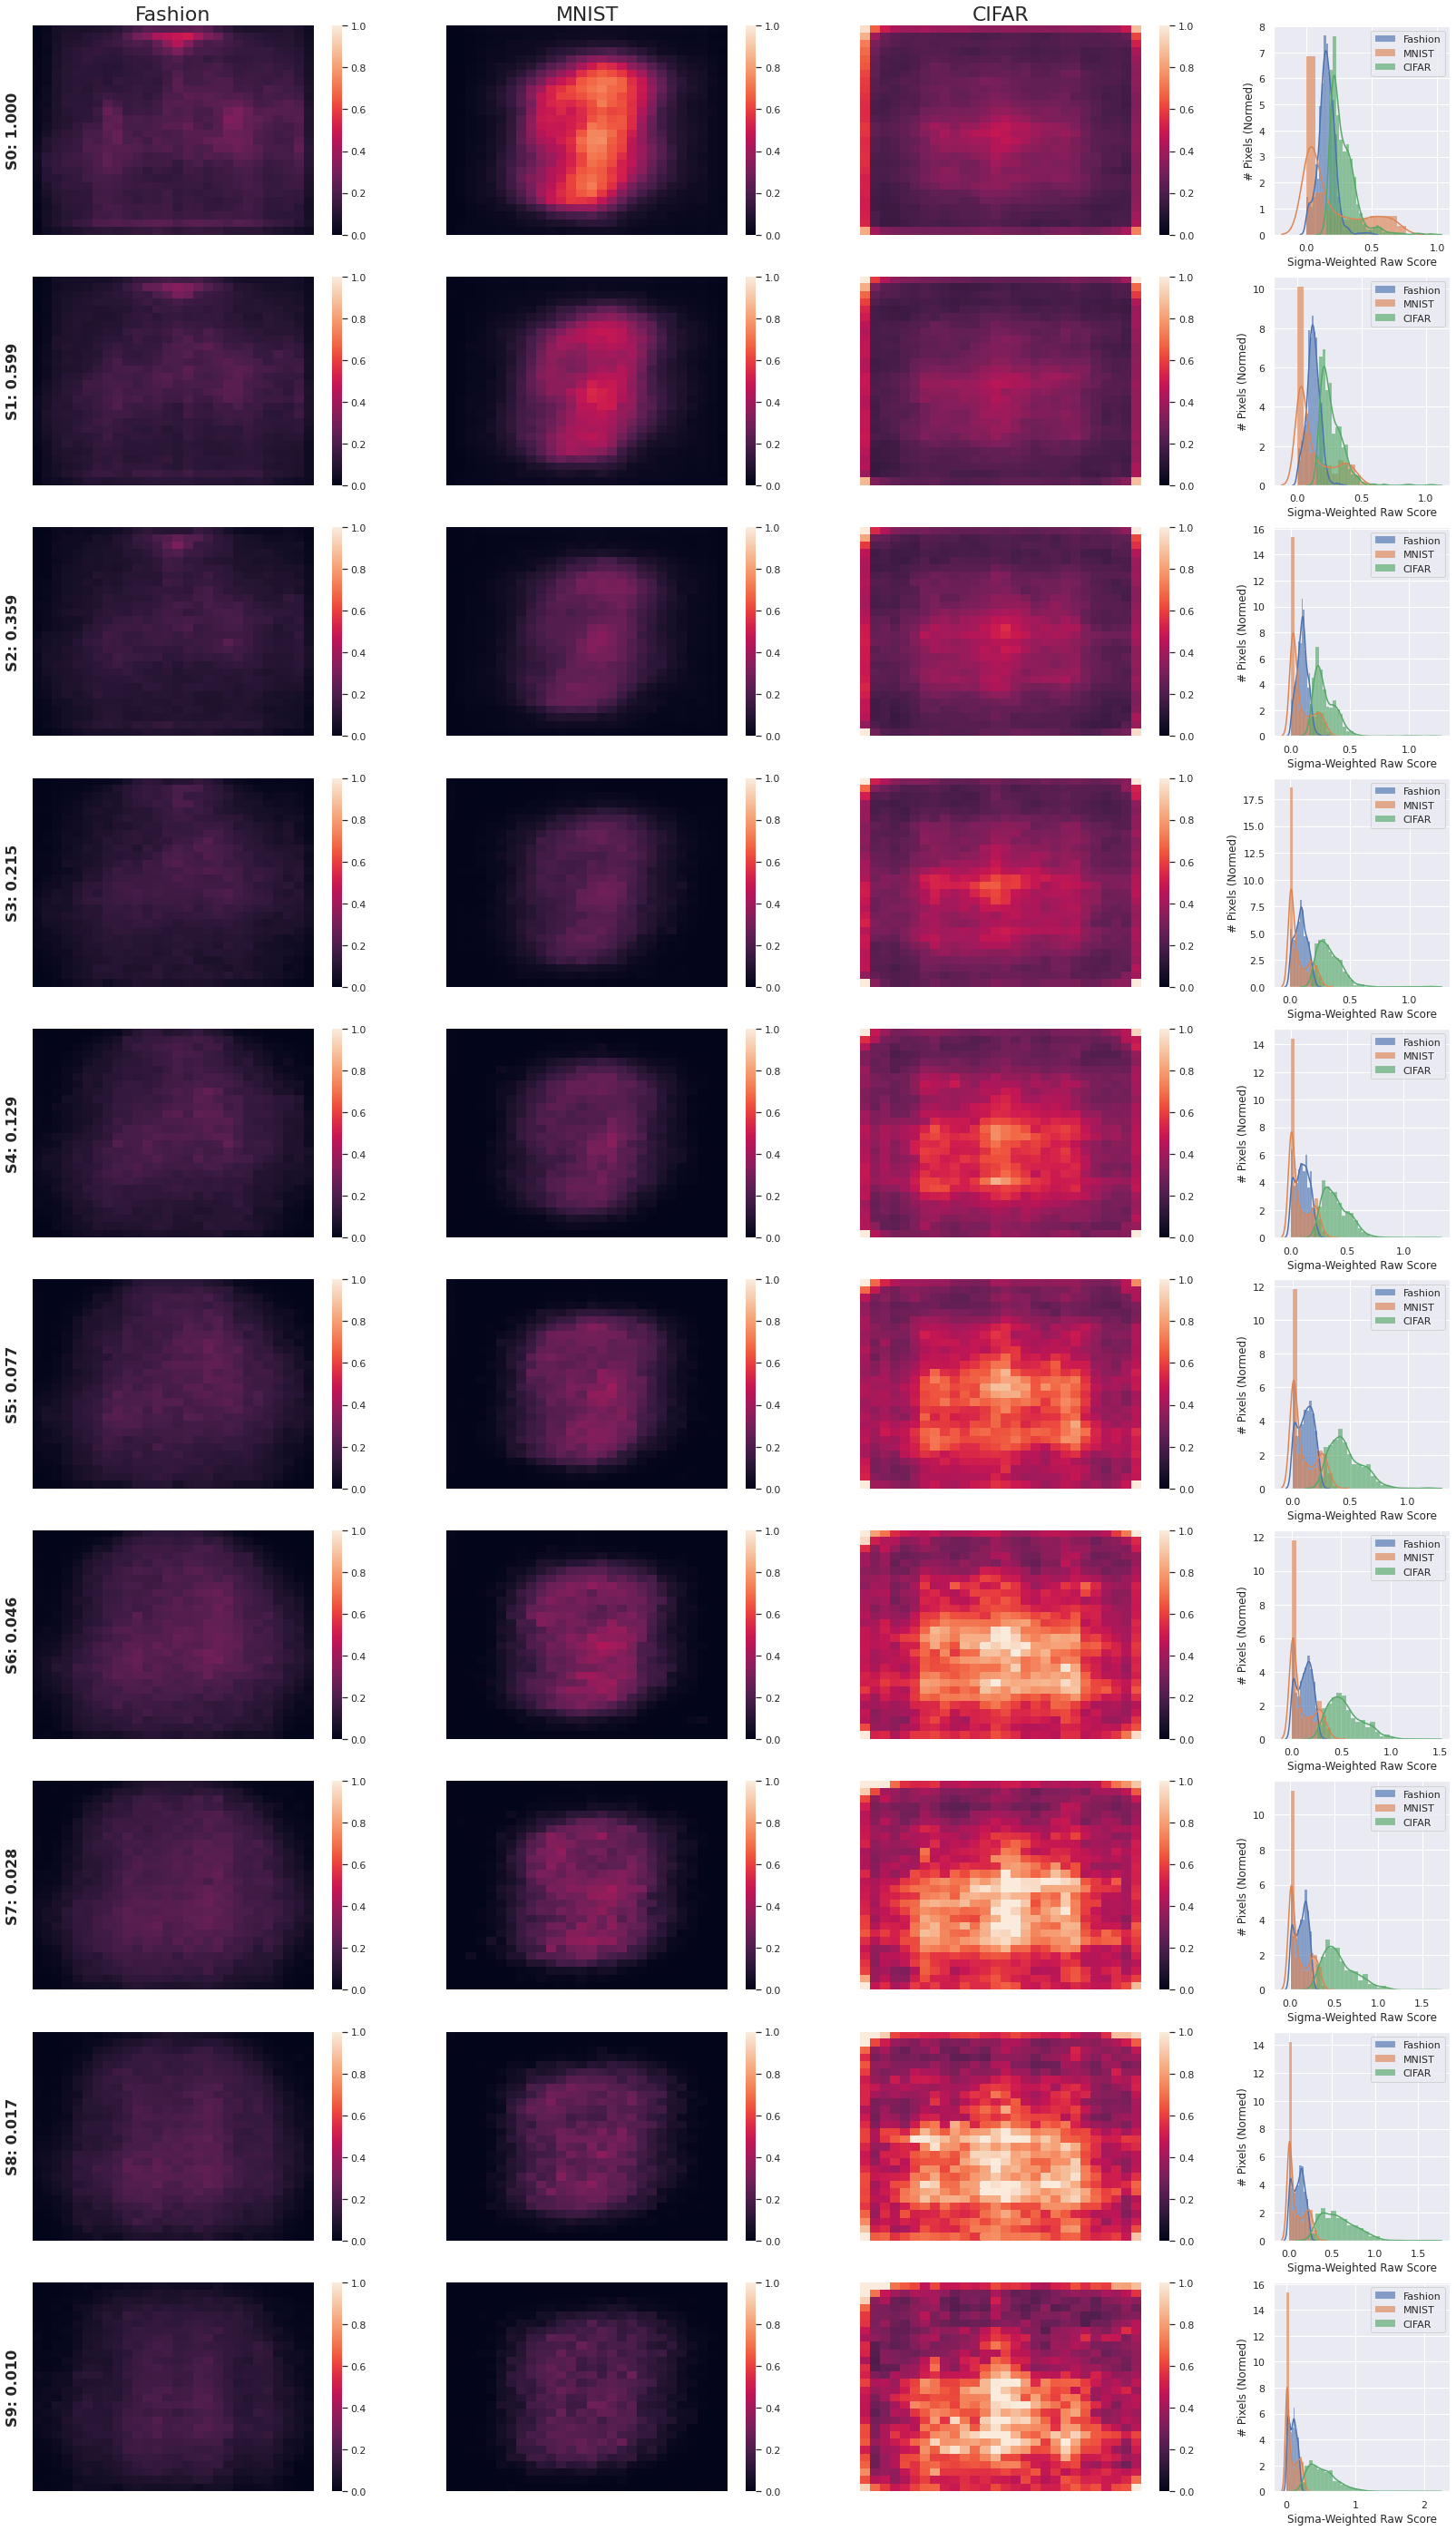

In [179]:
eps = 1e-3
fig, axs = plt.subplots(10, 4, figsize=(28, 50), gridspec_kw={'width_ratios': [2, 2, 2, 1]})
_labels = ["Fashion", "MNIST", "CIFAR"]
progress_bar = tqdm(sigmas, desc='Sigma: ?')

for idx, sigma in enumerate(progress_bar):
    for i, score_dist in enumerate([fashion_dist, mnist_dist, cifar_dist]):
        _logits = np.squeeze(score_dist[idx].numpy()) * sigma
        _logits = np.square(_logits)
        
        sigma_avg = np.mean(_logits, axis=0)
#         sigma_avg = np.abs(sigma_avg)
        

#         _logits[_logits < eps] = 0
        
        sns.heatmap(sigma_avg, ax=axs[idx][i], vmin=0.0, vmax=1.0)
        
        # Get rid of x/y ticks
        axs[idx][i].xaxis.set_visible(False)
        axs[idx][i].yaxis.set_ticklabels([])
        
        _ax = sns.distplot(sigma_avg[sigma_avg>eps], hist_kws={"alpha":0.65, "linewidth": 0.1}, ax=axs[idx][-1])
        
    axs[idx][0].set_ylabel("S{:d}: {:.3f}".format(idx, sigma), fontweight="bold", fontsize=16)
    _ax.set(xlabel="Sigma-Weighted Raw Score", ylabel="# Pixels (Normed)")    
    _ax.legend(_labels)

for i,lab in enumerate(_labels):
    axs[0][i].set_title(lab, fontsize=22)

plt.show()